## Simulations for JASA Paper

In [1]:
from math import ceil

from lightcurve_sims import classes
from lightcurve_sims import triggers
from lightcurve_sims import models

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter

from scipy.interpolate import interp1d

import pandas as pd
import numpy as np
float_formatter = "{:.7f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

import seaborn as sns

In [2]:
seeding = True

if seeding:
    seed_value = 42
    np.random.seed(seed_value)

In [3]:
model_ids = ['180703949','170803729','140624423','120427054', '150228845','190606080','080906212','090510016','140621827','101129726']

In [4]:
def binning(data, bin_width=0.05):
    grb_counts = pd.DataFrame(data)
    grb_counts[0] = grb_counts[0]-grb_counts.loc[0, 0]
    first = 0; last = grb_counts.iloc[-1, 0]

    bins = np.arange(first, last+bin_width, bin_width)
    bin_map = pd.cut(grb_counts[0], bins=bins).apply(lambda I: I.left)
    bin_series = pd.DataFrame(bin_map).groupby(0)[0].count()
    bin_df = pd.DataFrame({'count':bin_series})
    return bin_df

In [5]:
def window_detection(signal, λ, σ=5, hmax=128, spacing='logarithmic'):
    
    if spacing=='logarithmic':
        window_lengths = 2**(np.arange(0, np.ceil(np.log2(hmax)))).astype(int)
    else:
        window_lengths = np.arange(1, hmax+1)
    
    max_threshold=0
    best_window=1
    
    for h in window_lengths:
        
        data = signal.rolling(window=h).mean()
        μ = data/λ
        
        lr_statistic = 2*h*λ*(μ*np.log(μ)-μ+1) * (μ>1)
        
        
        if lr_statistic.max() > max_threshold:
            max_threshold = lr_statistic.max()
            best_window=h
        
    sigma_level = np.sqrt(max_threshold*2)
    return sigma_level

In [10]:
#simulation parameters
num = 0
model_id = model_ids[num]
sim_size=3
fluences=np.array([0, 100, 200, 400])
hmax=256
burst_time=2
np.random.seed(1)

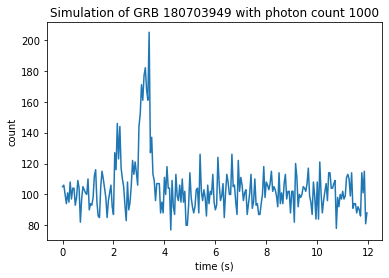

In [11]:
#plot of simulated GRB
bin_width=0.05
fluence=1000

lc = classes.LCSFromModel(duration = 12, burst_time = burst_time)
lc.simulate(model_id, duration_adjust=1)
lc.add_bkg(2000,is_flux = True)
lc.add_burst(fluence)

df = binning(lc.data, bin_width=bin_width)
plt.plot(df['count'].index, df['count'].values, label=f'bin width {bin_width}s')
plt.xlabel('time (s)')
plt.ylabel('count')
plt.title(f'Simulation of GRB {model_id} with photon count {fluence}')
plt.savefig(f'plots/grb{num}_pic.png', dpi=150)

In [16]:
#logarithmic

output_df = pd.DataFrame(data=np.zeros((sim_size, len(fluences))), columns=fluences)

for fluence in fluences:
    
    for sim in range(sim_size):
        np.random.seed(sim)

        lc = classes.LCSFromModel(duration = 10, burst_time = burst_time)
        lc.simulate(model_id, duration_adjust=1)
        lc.add_bkg(2000, is_flux = True)
        lc.add_burst(fluence)

        df = binning(lc.data, bin_width=0.05)

        output_df.loc[sim, fluence] = window_detection(df['count'], λ=100, hmax=hmax, spacing='logarithmic')

means = output_df.mean(axis=0).values

logarithmic_df = pd.DataFrame({'fluence':fluences, 'mean':means})
    

In [17]:
#exhaustive

output_df = pd.DataFrame(data=np.zeros((sim_size, len(fluences))), columns=fluences)

for fluence in fluences:
    
    for sim in range(sim_size):
        np.random.seed(sim)

        lc = classes.LCSFromModel(duration = 10, burst_time = burst_time)
        lc.simulate(model_id, duration_adjust=1)
        lc.add_bkg(2000, is_flux = True)
        lc.add_burst(fluence)

        df = binning(lc.data, bin_width=0.05)

        output_df.loc[sim, fluence] = window_detection(df['count'], λ=100, hmax=hmax, spacing='exhaustive')

means = output_df.mean(axis=0).values

exhaustive_df = pd.DataFrame({'fluence':fluences, 'mean':means})


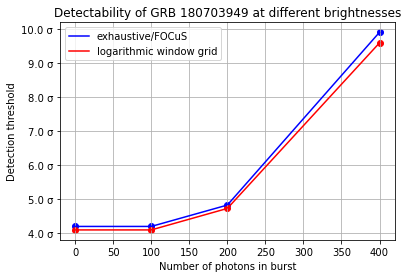

In [18]:
#plotting
interpolation='linear'

plt.scatter(exhaustive_df['fluence'], exhaustive_df['mean'], color='blue')
fit = interp1d(exhaustive_df['fluence'], exhaustive_df['mean'], kind=interpolation)
x=np.linspace(exhaustive_df['fluence'][0], exhaustive_df['fluence'][len(fluences)-1], 100)
plt.plot(x, fit(x), color='blue', label='exhaustive/FOCuS')

plt.scatter(logarithmic_df['fluence'], logarithmic_df['mean'], color='red')
fit = interp1d(logarithmic_df['fluence'], logarithmic_df['mean'], kind=interpolation)
x=np.linspace(logarithmic_df['fluence'][0], logarithmic_df['fluence'][len(fluences)-1], 100)
plt.plot(x, fit(x), color='red', label='logarithmic window grid')

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f σ'))
plt.title(f'Detectability of GRB {model_id} at different brightnesses')
plt.ylabel('Detection threshold')
plt.xlabel('Number of photons in burst')
plt.legend()

plt.grid(True)
plt.savefig(f'plots/grb{num}_sim.png', dpi=150)
plt.show()

140